# 3 Poznański Bieg Niepodległości

In 3 Poznański Bieg Niepodległości took part 22542 participants. 
I decided to analyse this race and answer a few basic questions. 
<br> Web scraping using synchronous requests, in this case, was slow and inefficient. 
<br> After research, I decided to use asynchronous web-scraping with asyncio module. <br> Surprisingly this way of solving problem boosted my web-scraper and decreased waiting time from about 10/9 minutes to 3/2 minutes. 

Analysis's questions:

> What is the average, minimal, maximal finish time for the participants?

> Did the participants finish times follow a normal distribution? 

> What age group was most popular?

> What are differences between males and females results?


We can split this analysis into 4 main parts:

* 1. Data extraction / web scraping
* 2. Data cleaning
* 3. Memory usage optimization
* 4. Data analysis and visualisation

In [39]:
# Importing Python's modules.
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import time

In [40]:
#URL with runners results during 3 Poznański Bieg Niepodległości.
URL = 'https://enduhub.com/pl/wyniki/2018/11/11/bieganie/3-poznanski-bieg-niepodleglosci,46448/'

## Web-Scraping with asyncio module

We are going to get results from each page using Python's web-scraper.
Requaierd modules:

* Asyncio is the asynchronous IO library that was introduced in python 3.4. Asyncio uses event loops, coroutines, and tasks to minimize idle time. <br> It's quite complex, for more informations check:

 > https://asyncio.readthedocs.io/en/latest/
 
 >https://medium.com/@santhoshhari/efficient-web-scraping-with-pythons-asynchronous-programming-6b9e730f1ff7

* Aiohttp creates HTTP client/server sessions for asyncio.
 

In [41]:
# Importing asyncio's modules.
import nest_asyncio
nest_asyncio.apply()
import asyncio
import aiohttp


async def fetch_url(session, url):
    ''' This function fetches URL from the website that you want to scrape. '''
    async with session.get(url, timeout=60*60) as response:
        return await response.text()

async def fetch_all_urls(session, urls, loop):
    ''' This function fetches all URLs from the website that you want to scrape. '''
    results = await asyncio.gather(*[fetch_url(session, url) for url in urls],
    return_exceptions=True)
    
    return results

def get_htmls(urls):
    ''' This function takes in a list of URLs, returns a list with URLs as keys
    and the HTML response returned by the web server as values.
    
    TCPConnector - to tweak or change transport layer of requests you can 
    pass a custom connector to ClientSession and family.
    '''
    if len(urls) > 1:
        loop = asyncio.get_event_loop()
        connector = aiohttp.TCPConnector(limit=10)
        async with aiohttp.ClientSession(loop=loop, connector=connector) as session:
            htmls = loop.run_until_complete(fetch_all_urls(session, urls, loop))
            raw_result = list(htmls)
    else:
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36(KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        raw_result = requests.get(urls[0], headers=headers).text

    return raw_result

def make_page_links(base_url):
    '''  This definition of function iterates over range of pages
    on website (in this case 266 pages) and returns list of all URLs. 
    '''
    pages = [base_url + '?page={}'.format(str(i)) for i in range(1,227)]
    
    return pages    

## Making DataFrame

My first idea was to do web-scraping using request and bs4 modules. Iteration over 226 pages took about 8-10 minutes.
<br> It was too long, so I decided to read about some optimization. I found really interesting article about an asynchronous
package called asyncio. 
<br> Using asynchronous web-scraping with asyncio module I saved up to 6 minutes (70 % of waiting time) durign scraping data from web.

In [42]:
%%time
url_list = make_page_links(URL)
raw_result = get_htmls(url_list)

CPU times: user 866 ms, sys: 133 ms, total: 998 ms
Wall time: 2min 38s


In [43]:
# Checking if we scraped all 226 pages.
len(raw_result)

226

We have our raw data. Now we need to extract from HTML parts like tables('tr', {'class' : 'row1 Zawody'}) and rows ('td').
<br> Then we need to convert a result into pandas DataFrame to prepare it for data wrangling and cleaning.
<br> In next step we will extract collumn names from first page on 'https://enduhub.com/pl/wyniki/2018/11/11/bieganie/3-poznanski-bieg-niepodleglosci,46448/'. <br> Finally we have to concat both objects and voilà our DataFrame is ready.

In [44]:
def make_table():
    ''' This function returns DataFrame that contains all 
    results (rows) from 3 Poznański Bieg Niepodległości. 
    Let's get ready to wrangle this Frame! 
    '''   
    list_rows = []
    for result in raw_result:
        content = BeautifulSoup(result, 'lxml').find_all('tr', {'class' : re.compile('row.*? Zawody')})
        for row in content:
            cells = row.find_all('td')
            str_cells = str(cells) 
            clean_cells = re.compile('<.*?>') 
            raw_rows = re.sub(clean_cells, '',str_cells)
            list_rows.append(raw_rows)
            
    return pd.DataFrame(list_rows)

## If you don't want to use regex, you can try this:
## clean_cells = BeautifulSoup(str_cells, 'html.parser').get_text()         

In [45]:
df1 = make_table()
df1.head(3)

,0
0,"[#1, \n, 1, 25000, Artur Kozłowski, Sieradz, P..."
1,"[#2, \n, 2, 24999, Tomasz Szymkowiak, Września..."
2,"[#3, \n, 3, 1858, Dawid Garski, Dąbie, POL, ML..."


## Data Cleaning 

Fun part. It is important to be able to deal with messy data, whether that means missing values, inconsistent formatting, <br> malformed records, or nonsensical outliers. The web-scraping result, in this case, HTML is always full of tricky commas and characters. <br> It is the best practice resource for learning data wrangling. In the beginning, we need to create DataFrame with separate columns.  <br> To do this we'll use expand argument inside the split function. 

In [50]:
df_test = df1[0].str.replace(', ', ',')

In [51]:
df_test = pd.DataFrame(df_test) 

In [52]:
df_test = df_test[:][0].str.split(',', expand=True)

After an investigation, I found tricky comma that broke table structure. Some of the runners included a few Klub names during registration, I assume. 
<br> I created function that counts commas in single row compare it with proper value (16). 
<br>  If the value is equal to 17 or 18 function splits row, gets first Klub name and creates a row with 16 commas.

In [53]:
df_test.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,[#1,\n,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,M30,1,1,-,00:15:47,00:31:02,00:31:01],None,None,None
1,[#2,\n,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,M30,2,2,-,00:15:47,00:31:22,00:31:21],None,None,None
2,[#3,\n,3,1858,Dawid Garski,Dąbie,POL,MLKS Baszta Bytów,1995,M20,1,3,-,00:16:21,00:32:33,00:32:32],None,None,None


In [54]:
df_test[8].value_counts().tail()

ZBIERAMY                    1
1942                        1
żeby móc pić dobre piwo!    1
POLSKA                      1
                            1
Name: 8, dtype: int64

In [55]:
print(len(df1))

22542


In [56]:
def tricky_comma(row):
    ''' This function splits row if there are more than 16 comas
    and creates right value.
    '''
    if row.count(',') == 16:
        return row.split(',')[:7][:] + row.split(',')[8:][:]
    elif row.count(',') == 17:
        return row.split(',')[:7][:] + row.split(',')[9:][:]
    elif row.count(',') == 18:
        return row.split(',')[:7][:] + row.split(',')[10:][:]
    else:
        return row

In [57]:
df2 = df1[0].apply(tricky_comma)

In [58]:
df2 = pd.DataFrame(df2)

In [59]:
df3 = df2[0].str.replace(', ', ',')

In [60]:
df4 = pd.DataFrame(df3)[0].str.split(',' , expand=True)

In [61]:
df4.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,[#1,\n,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,M30,1,1,-,00:15:47,00:31:02,00:31:01]
1,[#2,\n,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,M30,2,2,-,00:15:47,00:31:22,00:31:21]
2,[#3,\n,3,1858,Dawid Garski,Dąbie,POL,MLKS Baszta Bytów,1995,M20,1,3,-,00:16:21,00:32:33,00:32:32]


Cleaning proces includes:

* Dropping unnecessary characters like '[]#'
* Creating columns names
* Renaming columns
* Dropping unnecessary columns in a DataFrame
* Reseting the table's index
* Using capitalize() function on columns

In [62]:
df4[0] = df4[0].str.strip('[]#')
df4[15] = df4[15].str.strip('[]')

In [63]:
df4.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,\n,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,M30,1,1,-,00:15:47,00:31:02,00:31:01
1,2,\n,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,M30,2,2,-,00:15:47,00:31:22,00:31:21
2,3,\n,3,1858,Dawid Garski,Dąbie,POL,MLKS Baszta Bytów,1995,M20,1,3,-,00:16:21,00:32:33,00:32:32


In [64]:
def get_page(URL):
    '''  This function gets 1 argument and return
    BeautifulSoup object containing content of the page.    
    url - This is the url of website that you want to scrape.
    '''
    try:
        req = urlopen(URL)
    except requests.exceptions.RequestException:
        return None
    
    return BeautifulSoup(req.read(), 'lxml')

def get_col(URL):
    ''' This function gets 1 argument and return
    DataFrame containing raw headers of the socre table.    
    url - This is the url of website that you want to scrape.
    '''
    clean_headers = []
    page = get_page(URL)
    column_names = page.find_all('th')
    col_str = str(column_names)
    clean_headers.append(BeautifulSoup(col_str, 'lxml').get_text())
    
    return pd.DataFrame(clean_headers)

In [65]:
columns = get_col(URL)
columns.head()

,0
0,"[\n\n\n\n, \n\n\n\n\n\n\n\n\n\n, \n\n\n\n\nMsc..."


In [66]:
columns = columns[0].str.split(',', expand=True)
columns.iloc[0] = columns.iloc[0].str.replace('\n','').str.replace(' ','')

In [67]:
frames = [columns, df4]

In [68]:
df_table = pd.concat(frames, ignore_index=True)

In [69]:
df_table.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,[,,Msc,Nr,ImięNazwisko,Miejscowość,Kraj,Klub,Rok,Kat,MiejsceWKat,M,K,5Km,Wynik,Netto]
1,1,\n,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,M30,1,1,-,00:15:47,00:31:02,00:31:01
2,2,\n,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,M30,2,2,-,00:15:47,00:31:22,00:31:21


In [70]:
df_table2 = df_table.rename(columns=df_table.iloc[0])

In [236]:
df_table2.head(3)

,[,,Msc,Nr,ImięNazwisko,Miejscowość,Kraj,Klub,Rok,Kat,MiejsceWKat,M,K,5Km,Wynik,Netto]
0,[,,Msc,Nr,ImięNazwisko,Miejscowość,Kraj,Klub,Rok,Kat,MiejsceWKat,M,K,5Km,Wynik,Netto]
1,1,\n,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,M30,1,1,-,00:15:47,00:31:02,00:31:01
2,2,\n,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,M30,2,2,-,00:15:47,00:31:22,00:31:21


In [71]:
proper_columns = {'[': 'Index', 'Msc': 'Place', 'Nr': 'Number', 'Kraj': 'Country', 'M' : 'Male',
                  'ImięNazwisko':'Runner_name', 'Kat':'Category', 'Klub' : 'Club', 'K' : 'Female',
                  'Rok' : 'Year', 'MiejsceWKat': 'Place_in_cat', 'Wynik' : 'Score_time', 'Miejscowość': 'City',
                  'Netto]': 'Netto'}

df_table2.rename(columns=proper_columns, inplace=True)

In [72]:
df_table2.head(3)

,Index,,Place,Number,Runner_name,City,Country,Club,Year,Category,Place_in_cat,Male,Female,5Km,Score_time,Netto
0,[,,Msc,Nr,ImięNazwisko,Miejscowość,Kraj,Klub,Rok,Kat,MiejsceWKat,M,K,5Km,Wynik,Netto]
1,1,\n,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,M30,1,1,-,00:15:47,00:31:02,00:31:01
2,2,\n,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,M30,2,2,-,00:15:47,00:31:22,00:31:21


In [109]:
df_table3 = df_table2.drop(columns=['Index',''])

In [110]:
df_table3.drop(df_table3.index[0], inplace=True)

In [111]:
df_table3.head(3)

,Place,Number,Runner_name,City,Country,Club,Year,Category,Place_in_cat,Male,Female,5Km,Score_time,Netto
1,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,M30,1,1,-,00:15:47,00:31:02,00:31:01
2,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,M30,2,2,-,00:15:47,00:31:22,00:31:21
3,3,1858,Dawid Garski,Dąbie,POL,MLKS Baszta Bytów,1995,M20,1,3,-,00:16:21,00:32:33,00:32:32


In [112]:
df_table3['Category'].value_counts()

M30     5672
M40     4116
M20     3499
K30     2746
K20     1956
K40     1943
M50     1169
M16      406
K50      346
M60      340
K16      141
K60       69
M70+      50
K70+       3
Name: Category, dtype: int64

In [113]:
df_table3['City'] = df_table3['City'].astype(str)
df_table3['Category'] = df_table3['Category'].astype(str)

In [114]:
df_table3.loc[:,('City')] = df_table3.loc[:,('City')].apply(lambda x: x.title())

In [115]:
df_table3['Male'] = df_table3['Male'].apply(lambda x: 0 if x == '-' else 1)

In [116]:
df_table3['Female'] = df_table3['Female'].apply(lambda x: 0 if x == '-' else 1)

In [117]:
df_table3['Category'] = df_table3['Category'].apply(lambda x: x[1:])

In [118]:
df_table3.head(7)

,Place,Number,Runner_name,City,Country,Club,Year,Category,Place_in_cat,Male,Female,5Km,Score_time,Netto
1,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,30,1,1,0,00:15:47,00:31:02,00:31:01
2,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,30,2,1,0,00:15:47,00:31:22,00:31:21
3,3,1858,Dawid Garski,Dąbie,POL,MLKS Baszta Bytów,1995,20,1,1,0,00:16:21,00:32:33,00:32:32
4,4,22947,Adrian Bednarek,Bydgoszcz,POL,—,1990,20,2,1,0,00:16:37,00:32:38,00:32:37
5,5,23974,Krzysztof Jilek,Bystrzyca Kłodzka,POL,Ulks Bystrzyca Kłodzka/FIZJOTERAPEUTY/Biegi Śn...,1997,20,3,1,0,00:16:38,00:32:55,00:32:54
6,6,17330,Paweł Młodzikowski,Adamów,POL,Kb V-MAX Adamów,1987,30,3,1,0,00:16:41,00:33:34,00:33:33
7,7,18319,Paweł Raczyński,Krosno Odrzańskie,POL,5 kresowy batalion saperów Krosno Odrzańskie,1990,20,4,1,0,00:16:41,00:33:37,00:33:36


In [140]:
males.head()

,Place,Number,Runner_name,City,Country,Club,Year,Category,Place_in_cat,Male,Female,5Km,Score_time,Netto
1,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,30,1,1,0,00:15:47,00:31:02,00:31:01
2,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,30,2,1,0,00:15:47,00:31:22,00:31:21
3,3,1858,Dawid Garski,Dąbie,POL,MLKS Baszta Bytów,1995,20,1,1,0,00:16:21,00:32:33,00:32:32
4,4,22947,Adrian Bednarek,Bydgoszcz,POL,—,1990,20,2,1,0,00:16:37,00:32:38,00:32:37
5,5,23974,Krzysztof Jilek,Bystrzyca Kłodzka,POL,Ulks Bystrzyca Kłodzka/FIZJOTERAPEUTY/Biegi Śn...,1997,20,3,1,0,00:16:38,00:32:55,00:32:54


## Memory usage optimalization

I wrote a loop to iterate over each object column, check if the number of unique values is less than 50%, and if so, convert it to the category type.
<br> We've gone from 18.3 MB of memory usage to 7.4 MB of memory usage, or a 60% reduction! 

In [120]:
df_table3 = df_table3.dropna()
df_table3.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22456 entries, 1 to 22542
Data columns (total 14 columns):
Place           22456 non-null object
Number          22456 non-null object
Runner_name     22456 non-null object
City            22456 non-null object
Country         22456 non-null object
Club            22456 non-null object
Year            22456 non-null object
Category        22456 non-null object
Place_in_cat    22456 non-null object
Male            22456 non-null int64
Female          22456 non-null int64
5Km             22456 non-null object
Score_time      22456 non-null object
Netto           22456 non-null object
dtypes: int64(2), object(12)
memory usage: 18.0 MB


I needed to convert the list back into a dataframe and make a new column ("Runner_mins") for runner chip times expressed in just minutes.

In [121]:
mins = df_table3['Score_time'].dropna().tolist()

time_mins = []
for i in mins:
    h, m, s = i.split(':')
    math = (int(h) * 3600 + int(m) * 60 + int(s))/60
    time_mins.append(math)

df_table3['Runner_mins'] = time_mins

In [122]:
df_table3.head(3)

,Place,Number,Runner_name,City,Country,Club,Year,Category,Place_in_cat,Male,Female,5Km,Score_time,Netto,Runner_mins
1,1,25000,Artur Kozłowski,Sieradz,POL,Sanprobi Team,1985,30,1,1,0,00:15:47,00:31:02,00:31:01,31.033333
2,2,24999,Tomasz Szymkowiak,Września,POL,Krispol Active Team Września,1983,30,2,1,0,00:15:47,00:31:22,00:31:21,31.366667
3,3,1858,Dawid Garski,Dąbie,POL,MLKS Baszta Bytów,1995,20,1,1,0,00:16:21,00:32:33,00:32:32,32.550000


In [123]:
converted_obj = pd.DataFrame()

for col in df_table3.columns:
    num_unique_values = len(df_table3[col].unique())
    num_total_values = len(df_table3[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_table3[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_table3[col]

In [124]:
converted_obj.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22456 entries, 1 to 22542
Data columns (total 15 columns):
Place           22456 non-null object
Number          22456 non-null object
Runner_name     22456 non-null object
City            22456 non-null category
Country         22456 non-null category
Club            22456 non-null category
Year            22456 non-null category
Category        22456 non-null category
Place_in_cat    22456 non-null category
Male            22456 non-null category
Female          22456 non-null category
5Km             22456 non-null category
Score_time      22456 non-null category
Netto           22456 non-null category
Runner_mins     22456 non-null category
dtypes: category(12), object(3)
memory usage: 7.8 MB


In [125]:
start_mem_usg = df_table3.memory_usage(deep=True).sum() / 1024**2
mem_usg = converted_obj.memory_usage(deep=True).sum() / 1024**2

In [126]:
print("This is ",100* round(mem_usg/start_mem_usg,4) ,"% of the initial size.")

This is  41.93 % of the initial size.


# Data Analysis and Visualization

Now, let's answer questions that I asked at the beginning.
  > What is the average, minimal, maximal finish time for the participants?

In [129]:
df_table3['Runner_mins'].describe(include=[np.number]).to_frame()

,Runner_mins
count,22456.000000
mean,84.345481
std,23.594377
min,31.033333
25%,65.066667
50%,85.783333
75%,103.920833
max,147.950000


In [146]:
df_table3[['Runner_mins', 'Category']].groupby("Category", as_index=True).describe()

Runner_mins                                                         \
               count       mean        std        min        25%        50%   
Category                                                                      
16             547.0  86.307952  23.962369  34.833333  67.166667  91.733333   
20            5455.0  87.254760  23.499446  32.550000  68.433333  91.850000   
30            8418.0  83.289451  23.670973  31.033333  63.654167  84.350000   
40            6059.0  83.001384  23.516728  34.916667  63.491667  83.600000   
50            1515.0  83.453938  22.759092  35.216667  65.516667  82.800000   
60             409.0  86.627465  23.596666  39.616667  69.483333  86.083333   
70+             53.0  93.917296  19.893657  42.766667  78.900000  96.216667   

                                  
                 75%         max  
Category                          
16        105.891667  140.683333  
20        106.216667  147.716667  
30        103.150000  146.200000  
40        102.216667  147.950000  
50        101.708333  140.966667  
60        103.233333  144.100000  
70+       106.583333  136.933333

The average running time for all runners was ~85 mins. <br> The fastest runner finished 5km in 36 mins, and the slowest runner finished race in 148 minutes.

 > Did the participants finish times follow a normal distribution?

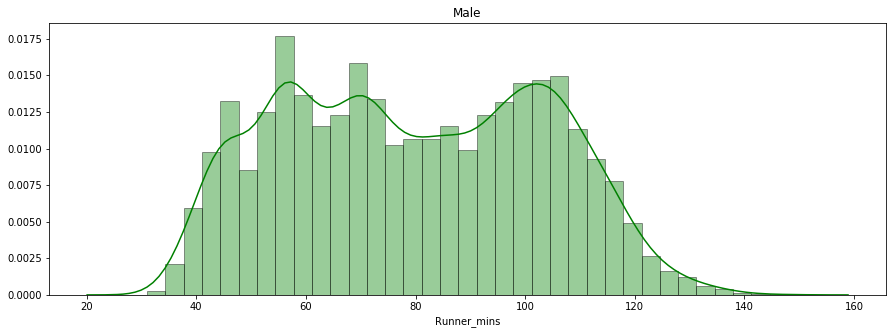

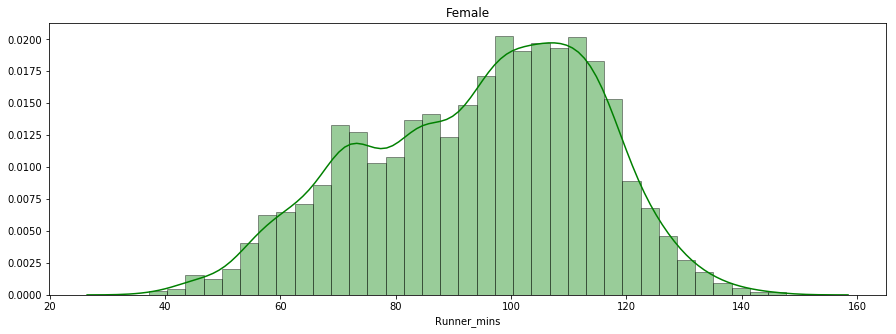

In [135]:
# Importing fig params
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

# Creating hisgograms for males and females
for x in 'Male Female'.split(' '):
    gender = df_table3[df_table3[str(x)] == 1]['Runner_mins']
    ax = sns.distplot(gender, hist=True, kde=True, rug=False, 
                      color='g', bins=35, hist_kws={'edgecolor':'black'})
    plt.title(x)
    plt.show()

As we can see the distribution looks almost normal for males and females.

> What are differences between males and females results along various age groups?

In [138]:
import plotly.plotly as py
import plotly.graph_objs as go


fig = {
  "data": [
    {
      "values": males['Category'].value_counts(),
      "labels": list(dict(df_table3[df_table3['Male'] == 1]['Category'].value_counts()).keys()),
      "domain": {"x": [0, .48]},
      "name": "Males",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },
    {
      "values": females['Category'].value_counts(),
      "labels": list(dict(df_table3[df_table3['Female'] == 1]['Category'].value_counts()).keys()),
      "textposition":"inside",
      "domain": {"x": [.52, 1]},
      "name": "Females",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Category percentage share",
        "annotations": [
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": "Males",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": "Females",
                "x": 0.81,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig, filename='donut')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



<br> These pie charts are prepared using plot.ly - one of my favourites visualisation libraries.
<br> The category percentage share is similar in both cases (male, female). The most numerous group is 30+ years old.
<br> The second most numerous group is different in both cases, for men, it is 40+  years old and for women, it is 20+ years old. 

> What are differences between males and females results?

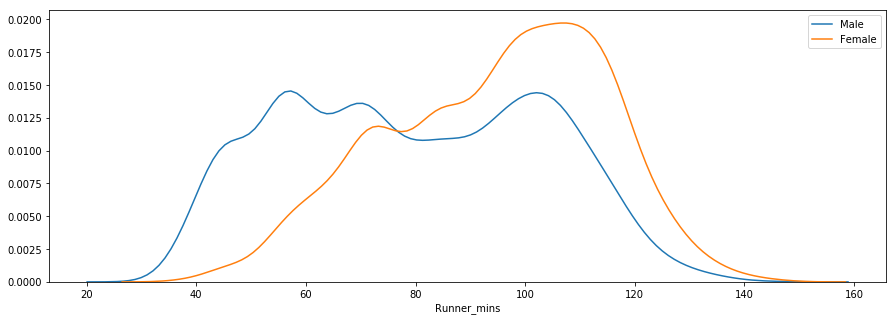

In [142]:
males = df_table3[df_table3['Male'] == 1]
females = df_table3[df_table3['Female'] == 1]

sns.distplot(males['Runner_mins'], hist=False, kde=True,
             rug=False, hist_kws={'edgecolor':'black'},
             label='Male')
sns.distplot(females['Runner_mins'], hist=False, kde=True,
             rug=False, hist_kws={'edgecolor':'black'},
             label='Female')
plt.legend()

The distribution shows that females were slower than males on average. Men dominate race in scores up to 60 minutes.